In [2]:
from pathlib import Path
from reload_recursive import reload_recursive
import mri_data
import monai_training
import platform
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger
from tqdm.notebook import tqdm
import pandas as pd

import logging

from scipy.spatial import ConvexHull, convex_hull_plot_2d, distance
from scipy import ndimage
from sklearn.cluster import HDBSCAN

In [3]:
reload_recursive(mri_data)
reload_recursive(monai_training)
from mri_data.file_manager import scan_3Tpioneer_bids, DataSet, filter_first_ses  # noqa: E402, F401
import mri_data.file_manager as fm
from mri_data import utils
from monai_training import preprocess  # noqa: E402
from monai_training.preprocess import DataSetProcesser

In [4]:
logger.remove()
logging.basicConfig(level=logging.ERROR)

In [5]:
hostname = platform.node()
if hostname == "rhinocampus":
    drive_root = Path("/media/smbshare")
else:
    drive_root = Path("/mnt/h")

projects_root = Path("/home/srs-9/Projects")
training_work_dirs = drive_root / "training_work_dirs"
msmri_home = projects_root / "ms_mri"
project_dataroot = msmri_home / "data"

prediction_postfix = "choroid_pineal_pituitary3_pred"
modalities = ["flair", "t1"]

inference_root = drive_root / "3Tpioneer_bids_predictions"
prediction_filename = (
    ".".join(sorted(modalities)) + "_" + prediction_postfix + ".nii.gz"
)
dataroot = drive_root / "3Tpioneer_bids"
work_dir_name = "choroid_pineal_pituitary3"
work_dir = training_work_dirs / work_dir_name
ensemble_out_dir = work_dir / "ensemble_output"

In [6]:
inference_proc = DataSetProcesser.new_dataset(
    inference_root, scan_3Tpioneer_bids, filters=[fm.filter_first_ses],
    label=prediction_filename
)
inference_proc.filter([fm.has_label])
inference_proc.dataset.sort()
inference_dataset = inference_proc.dataset
# inference_dataset = [scan for scan in inference_dataset if scan.label is not None]

In [7]:
dataset_proc = DataSetProcesser.new_dataset(dataroot, fm.scan_3Tpioneer_bids, filters=[fm.filter_first_ses])
dataset_proc.prepare_labels(["choroid_t1_flair", "pineal", "pituitary"], suffix_list=["CH", "SRS", "ED", "DT"])
dataset = dataset_proc.dataset
dataset.sort()

100%|██████████| 575/575 [00:16<00:00, 34.18it/s]


In [8]:
scans = dataset.scans + inference_dataset.scans

In [9]:
def load_segmentation(scan, label=None):
    seg = nib.load(scan.label_path).get_fdata()
    if label is None:
        return seg
    
    labels = ["choroid", "pineal", "pituitary"]
    try:
        val = labels.index(label) + 1
    except ValueError:
        print(f"Invalid value for label passed ({label})")
        raise

    seg_all = seg
    seg[seg_all != val] = 0
    seg[seg_all == val] = 1
    return seg

def split_segmentation(seg):
    seg_all = seg
    segs = []
    for val in range(1, int(np.max(seg))+1):
        seg[seg_all != val] = 0
        seg[seg_all == val] = 1
        segs.append(seg)
    
    return segs

In [10]:
def centroid_dists(seg):
    points = np.argwhere(seg > 0)
    hdb = HDBSCAN()
    hdb.store_centers = "centroid"
    hdb.fit(points)
    centroid = ndimage.center_of_mass(seg)

    w_sum = 0
    for i in range(np.max(hdb.labels_) + 1):
        w_sum = w_sum + distance.euclidean(centroid, hdb.centroids_[i]) * sum(hdb.labels_ == i) / len(points)
    
    return w_sum

def get_volumes(scan):
    vol_stats = utils.compute_volume(scan.label_path, index_mask_file=scan.label_path)
    
    return tuple([stat[1] for stat in vol_stats])

In [11]:
all_segs = (split_segmentation(load_segmentation(scan)) for scan in scans)

In [12]:
keep_cols = ["ms_type"]
df_full = pd.read_csv(project_dataroot / "clinical_data_full.csv", index_col="subid")
df_full = df_full[keep_cols]
try:
    df_full.insert('dz_type', df_full['ms_type'])
except Exception:
    pass

df_full.loc[:, 'dz_type'] = df_full['ms_type']

df_full.loc[df_full['ms_type'] == 'CIS', 'dz_type'] = 'RRMS'
df_full.loc[df_full['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type'] = 'PMS'
df_full.loc[df_full['ms_type'].isin(['NIND', 'OIND', 'HC']), 'dz_type'] = '!MS'

df_full.loc[:, 'dz_type2'] = df_full['dz_type']
df_full.loc[df_full['dz_type'].isin(['RRMS', 'PMS']), 'dz_type2'] = 'MS'

In [13]:
load_vols = True
if load_vols:
    vols_arr = np.load('volumes.npy')
    vol_sub_arr = np.load('volumes_subjects.npy')
else:
    vols = []
    for scan in tqdm(scans):
        try:
            vol = get_volumes(scan)
        except Exception:
            continue

        try:
            assert len(vol) == 3
        except AssertionError:
            pass

        vols.append((scan.subid, vol))


    vols_arr = np.stack([vol[1] for vol in vols])
    vol_sub_arr = np.array([vol[0] for vol in vols])
    np.save('volumes.npy', vols_arr)
    np.save('volumes_subjects.npy', vol_sub_arr)

In [14]:
df = pd.DataFrame(vols_arr, 
             index=[int(sub) for sub in vol_sub_arr], 
             columns=["choroid_volume", "pineal_volume", "pituitary_volume"])

df['dz_type'] = df_full['dz_type']
df['dz_type2'] = df_full['dz_type2']

Volume Histograms

In [15]:
choroid_ms_mean = df[df['dz_type'] == "RRMS"].choroid_volume.mean()
choroid_notms_mean = df[df['dz_type'] == "!MS"].choroid_volume.mean()

pineal_ms_mean = df[df['dz_type'] == "RRMS"].pineal_volume.mean()
pineal_notms_mean = df[df['dz_type'] == "!MS"].pineal_volume.mean()

pituitary_ms_mean = df[df['dz_type'] == "RRMS"].pituitary_volume.mean()
pituitary_notms_mean = df[df['dz_type'] == "!MS"].pituitary_volume.mean()

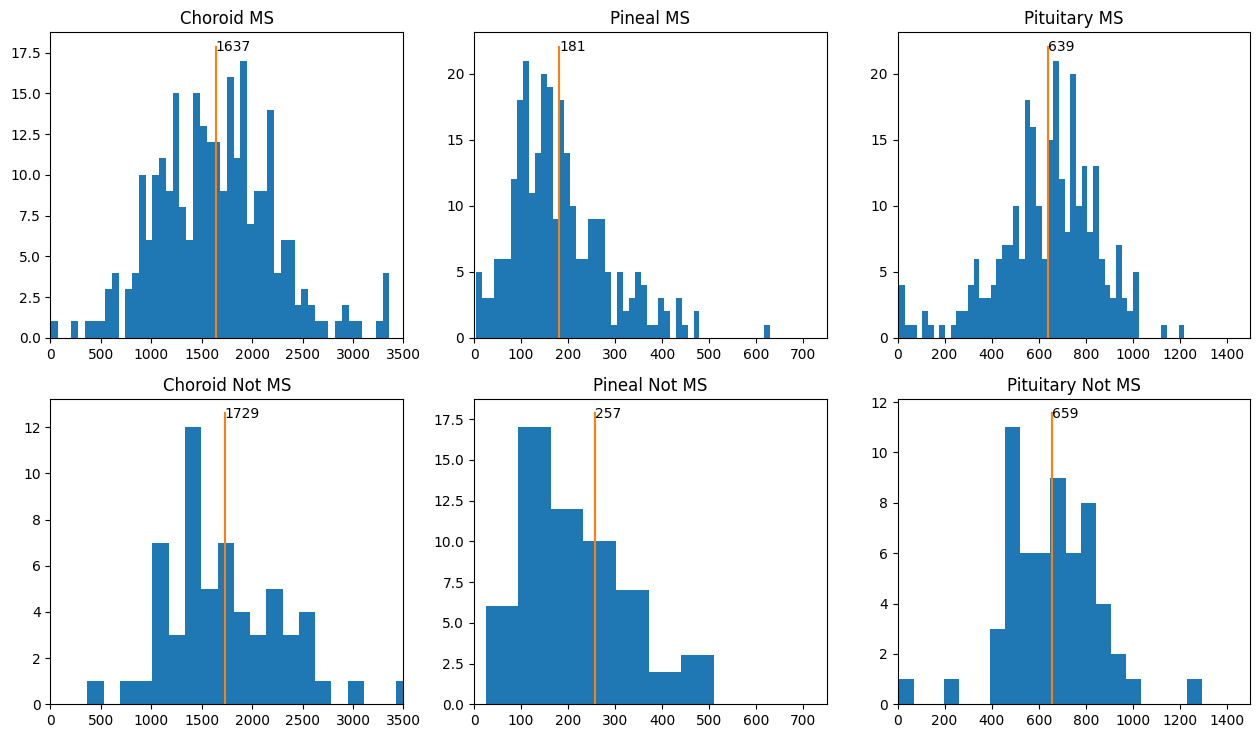

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df.loc[df['dz_type']=='RRMS', 'choroid_volume'], bins=50)
ax[0,0].set_xlim([0, 3500])
ax[0,0].set_title("Choroid MS")
ax[0,0].plot([choroid_ms_mean, choroid_ms_mean], ax[0,0].get_ylim())
text_y = ax[0,0].get_ylim()[1] - ax[0,0].get_ylim()[1] / 16
ax[0,0].text(choroid_ms_mean, text_y, "{:0.0f}".format(choroid_ms_mean))

ax[1, 0].hist(df.loc[df['dz_type']=='!MS', 'choroid_volume'], bins=20)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1,0].plot([choroid_notms_mean, choroid_notms_mean], ax[1,0].get_ylim())
text_y = ax[1,0].get_ylim()[1] - ax[1,0].get_ylim()[1] / 16
ax[1,0].text(choroid_notms_mean, text_y, "{:0.0f}".format(choroid_notms_mean))


ax[0,1].hist(df.loc[df['dz_type']=='RRMS', 'pineal_volume'], bins=50)
ax[0,1].set_xlim([0, 750])
ax[0,1].set_title("Pineal MS")
ax[0,1].plot([pineal_ms_mean, pineal_ms_mean], ax[0,1].get_ylim())
text_y = ax[0,1].get_ylim()[1] - ax[0,1].get_ylim()[1] / 16
ax[0,1].text(pineal_ms_mean, text_y, "{:0.0f}".format(pineal_ms_mean))

ax[1,1].hist(df.loc[df['dz_type']=='!MS', 'pineal_volume'], bins=30)
ax[1,1].set_xlim([0, 750])
ax[1,1].set_title("Pineal Not MS")
ax[1,1].plot([pineal_notms_mean, pineal_notms_mean], ax[1,1].get_ylim())
text_y = ax[1,1].get_ylim()[1] - ax[1,1].get_ylim()[1] / 16
ax[1,1].text(pineal_notms_mean, text_y, "{:0.0f}".format(pineal_notms_mean))


ax[0,2].hist(df.loc[df['dz_type']=='RRMS', 'pituitary_volume'], bins=50)
ax[0,2].set_xlim([0, 1500])
ax[0,2].set_title("Pituitary MS")
ax[0,2].plot([pituitary_ms_mean, pituitary_ms_mean], ax[0,2].get_ylim())
text_y = ax[0,2].get_ylim()[1] - ax[0,2].get_ylim()[1] / 16
ax[0,2].text(pituitary_ms_mean, text_y, "{:0.0f}".format(pituitary_ms_mean))

ax[1,2].hist(df.loc[df['dz_type']=='!MS', 'pituitary_volume'], bins=20)
ax[1,2].set_xlim([0, 1500])
ax[1,2].set_title("Pituitary Not MS")
ax[1,2].plot([pituitary_notms_mean, pituitary_notms_mean], ax[1,2].get_ylim())
text_y = ax[1,2].get_ylim()[1] - ax[1,2].get_ylim()[1] / 16
ax[1,2].text(pituitary_notms_mean, text_y, "{:0.0f}".format(pituitary_notms_mean))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

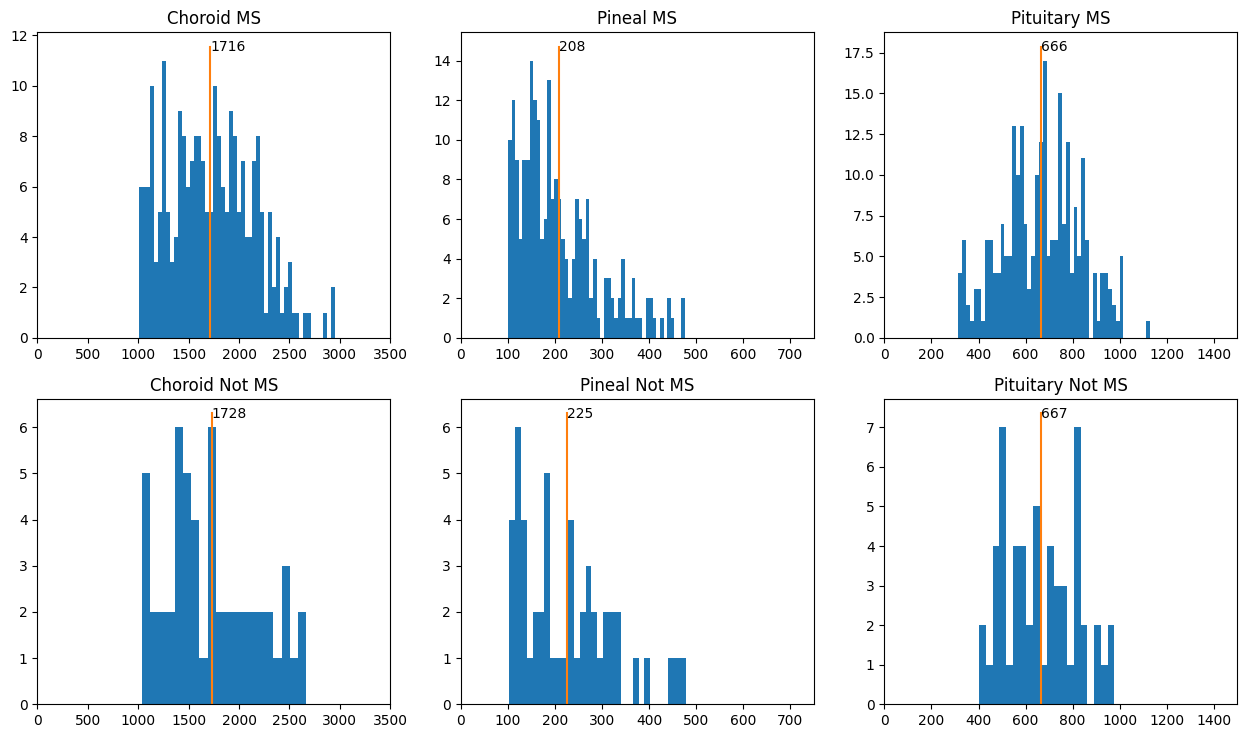

In [29]:
import matplotlib.pyplot as plt

df2 = df[(df['choroid_volume'] > 1000) & (df['choroid_volume'] < 3000)]

choroid_ms_mean2 = df2[df2['dz_type'] == "RRMS"].choroid_volume.mean()
choroid_notms_mean2 = df2[df2['dz_type'] == "!MS"].choroid_volume.mean()

fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df2.loc[df2['dz_type']=='RRMS', 'choroid_volume'], bins=50)
ax[0,0].set_xlim([0, 3500])
ax[0,0].set_title("Choroid MS")
ax[0,0].plot([choroid_ms_mean2, choroid_ms_mean2], ax[0,0].get_ylim())
text_y = ax[0,0].get_ylim()[1] - ax[0,0].get_ylim()[1] / 16
ax[0,0].text(choroid_ms_mean2, text_y, "{:0.0f}".format(choroid_ms_mean2))

ax[1, 0].hist(df2.loc[df2['dz_type']=='!MS', 'choroid_volume'], bins=20)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1,0].plot([choroid_notms_mean2, choroid_notms_mean2], ax[1,0].get_ylim())
text_y = ax[1,0].get_ylim()[1] - ax[1,0].get_ylim()[1] / 16
ax[1,0].text(choroid_notms_mean2, text_y, "{:0.0f}".format(choroid_notms_mean2))


df3 = df[(df['pineal_volume'] > 100) & (df['pineal_volume'] < 500)]
pineal_ms_mean3 = df3[df3['dz_type'] == "RRMS"].pineal_volume.mean()
pineal_notms_mean3 = df3[df3['dz_type'] == "!MS"].pineal_volume.mean()

ax[0,1].hist(df3.loc[df3['dz_type']=='RRMS', 'pineal_volume'], bins=50)
ax[0,1].set_xlim([0, 750])
ax[0,1].set_title("Pineal MS")
ax[0,1].plot([pineal_ms_mean3, pineal_ms_mean3], ax[0,1].get_ylim())
text_y = ax[0,1].get_ylim()[1] - ax[0,1].get_ylim()[1] / 16
ax[0,1].text(pineal_ms_mean3, text_y, "{:0.0f}".format(pineal_ms_mean3))

ax[1,1].hist(df3.loc[df3['dz_type']=='!MS', 'pineal_volume'], bins=30)
ax[1,1].set_xlim([0, 750])
ax[1,1].set_title("Pineal Not MS")
ax[1,1].plot([pineal_notms_mean3, pineal_notms_mean3], ax[1,1].get_ylim())
text_y = ax[1,1].get_ylim()[1] - ax[1,1].get_ylim()[1] / 16
ax[1,1].text(pineal_notms_mean3, text_y, "{:0.0f}".format(pineal_notms_mean3))


df4 = df[(df['pituitary_volume'] > 300) & (df['pituitary_volume'] < 1200)]
pituitary_ms_mean4 = df4[df4['dz_type'] == "RRMS"].pituitary_volume.mean()
pituitary_notms_mean4 = df4[df4['dz_type'] == "!MS"].pituitary_volume.mean()

ax[0,2].hist(df4.loc[df4['dz_type']=='RRMS', 'pituitary_volume'], bins=50)
ax[0,2].set_xlim([0, 1500])
ax[0,2].set_title("Pituitary MS")
ax[0,2].plot([pituitary_ms_mean4, pituitary_ms_mean4], ax[0,2].get_ylim())
text_y = ax[0,2].get_ylim()[1] - ax[0,2].get_ylim()[1] / 16
ax[0,2].text(pituitary_ms_mean4, text_y, "{:0.0f}".format(pituitary_ms_mean4))

ax[1,2].hist(df4.loc[df4['dz_type']=='!MS', 'pituitary_volume'], bins=20)
ax[1,2].set_xlim([0, 1500])
ax[1,2].set_title("Pituitary Not MS")
ax[1,2].plot([pituitary_notms_mean4, pituitary_notms_mean4], ax[1,2].get_ylim())
text_y = ax[1,2].get_ylim()[1] - ax[1,2].get_ylim()[1] / 16
ax[1,2].text(pituitary_notms_mean4, text_y, "{:0.0f}".format(pituitary_notms_mean4))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

In [31]:
subjects = [
    1010,
    1011,
    1019,
    1033,
    1065,
    1080,
    1109,
    1119,
    1152,
    1163,
    1188,
    1191,
    1234,
    1259,
    1265,
    1272,
    1280,
    1293,
    1321,
    1355,
    1437,
    1486,
    1498,
    1518,
    1540,
    1547,
    1548,
    2081,
    2083,
    2097,
    2126,
    2132,
    2144,
    2146,
    2164,
    2187,
]

In [34]:
df_subset = df.loc[subjects]

choroid_ms_mean_subset = df_subset[df_subset['dz_type'] == "RRMS"].choroid_volume.mean()
choroid_notms_mean_subset = df_subset[df_subset['dz_type'] == "!MS"].choroid_volume.mean()

pineal_ms_mean_subset = df_subset[df_subset['dz_type'] == "RRMS"].pineal_volume.mean()
pineal_notms_mean_subset = df_subset[df_subset['dz_type'] == "!MS"].pineal_volume.mean()

pituitary_ms_mean_subset = df_subset[df_subset['dz_type'] == "RRMS"].pituitary_volume.mean()
pituitary_notms_mean_subset = df_subset[df_subset['dz_type'] == "!MS"].pituitary_volume.mean()

print(choroid_ms_mean_subset, choroid_notms_mean_subset)
print(pineal_ms_mean_subset, pineal_notms_mean_subset)
print(pituitary_ms_mean_subset, pituitary_notms_mean_subset)

1938.0617409375 1876.800886545455
253.981841875 358.5155316818181
791.450225875 669.0192705000001


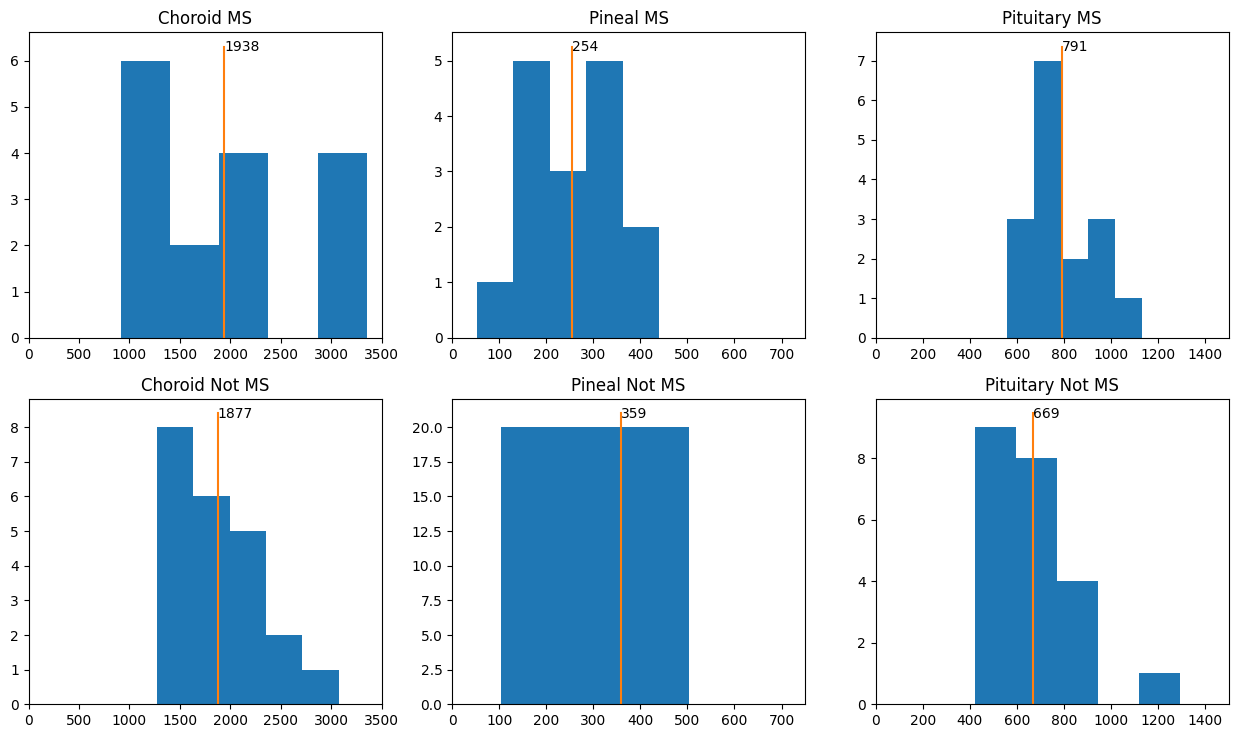

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df_subset.loc[df_subset['dz_type']=='RRMS', 'choroid_volume'], bins=5)
ax[0,0].set_xlim([0, 3500])
ax[0,0].set_title("Choroid MS")
ax[0,0].plot([choroid_ms_mean_subset, choroid_ms_mean_subset], ax[0,0].get_ylim())
text_y = ax[0,0].get_ylim()[1] - ax[0,0].get_ylim()[1] / 16
ax[0,0].text(choroid_ms_mean_subset, text_y, "{:0.0f}".format(choroid_ms_mean_subset))

ax[1, 0].hist(df_subset.loc[df_subset['dz_type']=='!MS', 'choroid_volume'], bins=5)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1,0].plot([choroid_notms_mean_subset, choroid_notms_mean_subset], ax[1,0].get_ylim())
text_y = ax[1,0].get_ylim()[1] - ax[1,0].get_ylim()[1] / 16
ax[1,0].text(choroid_notms_mean_subset, text_y, "{:0.0f}".format(choroid_notms_mean_subset))


ax[0,1].hist(df_subset.loc[df_subset['dz_type']=='RRMS', 'pineal_volume'], bins=5)
ax[0,1].set_xlim([0, 750])
ax[0,1].set_title("Pineal MS")
ax[0,1].plot([pineal_ms_mean_subset, pineal_ms_mean_subset], ax[0,1].get_ylim())
text_y = ax[0,1].get_ylim()[1] - ax[0,1].get_ylim()[1] / 16
ax[0,1].text(pineal_ms_mean_subset, text_y, "{:0.0f}".format(pineal_ms_mean_subset))

ax[1,1].hist(df_subset.loc[df_subset['dz_type']=='!MS', 'pineal_volume'], bins=5)
ax[1,1].set_xlim([0, 750])
ax[1,1].set_title("Pineal Not MS")
ax[1,1].plot([pineal_notms_mean_subset, pineal_notms_mean_subset], ax[1,1].get_ylim())
text_y = ax[1,1].get_ylim()[1] - ax[1,1].get_ylim()[1] / 16
ax[1,1].text(pineal_notms_mean_subset, text_y, "{:0.0f}".format(pineal_notms_mean_subset))


ax[0,2].hist(df_subset.loc[df_subset['dz_type']=='RRMS', 'pituitary_volume'], bins=5)
ax[0,2].set_xlim([0, 1500])
ax[0,2].set_title("Pituitary MS")
ax[0,2].plot([pituitary_ms_mean_subset, pituitary_ms_mean_subset], ax[0,2].get_ylim())
text_y = ax[0,2].get_ylim()[1] - ax[0,2].get_ylim()[1] / 16
ax[0,2].text(pituitary_ms_mean_subset, text_y, "{:0.0f}".format(pituitary_ms_mean_subset))

ax[1,2].hist(df_subset.loc[df_subset['dz_type']=='!MS', 'pituitary_volume'], bins=5)
ax[1,2].set_xlim([0, 1500])
ax[1,2].set_title("Pituitary Not MS")
ax[1,2].plot([pituitary_notms_mean_subset, pituitary_notms_mean_subset], ax[1,2].get_ylim())
text_y = ax[1,2].get_ylim()[1] - ax[1,2].get_ylim()[1] / 16
ax[1,2].text(pituitary_notms_mean_subset, text_y, "{:0.0f}".format(pituitary_notms_mean_subset))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

In [114]:
print(df[df['dz_type'] == "RRMS"].choroid_volume.mean())
print(df[df['dz_type'] == "!MS"].choroid_volume.mean())

1637.3970386996336
1728.9817411016948


In [52]:
df2 = df[(df['pineal_volume'] < 500)]
print(df2[df2['dz_type'] == "RRMS"].pineal_volume.mean())
print(df2[df2['dz_type'] == "!MS"].pineal_volume.mean())

179.6138000882353
208.3467729649123


In [ ]:
for scan in scans:
    utils.

In [7]:
scan = dataset[0]
seg = nib.load(scan.label_path).get_fdata()
seg_pineal = seg
seg_pineal[seg!=2] = 0
seg_pineal[seg==2] = 1
pineal_points = np.argwhere(seg_pineal > 0)

In [31]:
hdb = HDBSCAN()
hdb.store_centers = "centroid"
hdb.fit(pineal_points)
centroid = ndimage.center_of_mass(seg_pineal)

w_sum = 0
for i in range(np.max(hdb.labels_) + 1):
    w_sum = w_sum + distance.euclidean(centroid, hdb.centroids_[i]) * sum(hdb.labels_ == i) / len(pineal_points)

w_sum

64.7509172077051

In [34]:
w_sums = []
for scan in ensemble_out_dataset:
    seg = nib.load(scan.label_path).get_fdata()
    seg_pineal = seg
    seg_pineal[seg!=2] = 0
    seg_pineal[seg==2] = 1
    w_sums.append(centroid_dists(seg_pineal))
print(w_sums)

[64.7509172077051, 0.11347538344258354, 0.22073064671848758, 0.15279016398402023, 0.15286860494798088, 0.12900301472133338, 0.16262856846472876, 0.12601288580414272, 7.560643004736136, 0.11389466194400648]


In [15]:
thoo = [list() for i in range(3)]
thoo[0].append(1)
print(thoo)

[[1], [], []]


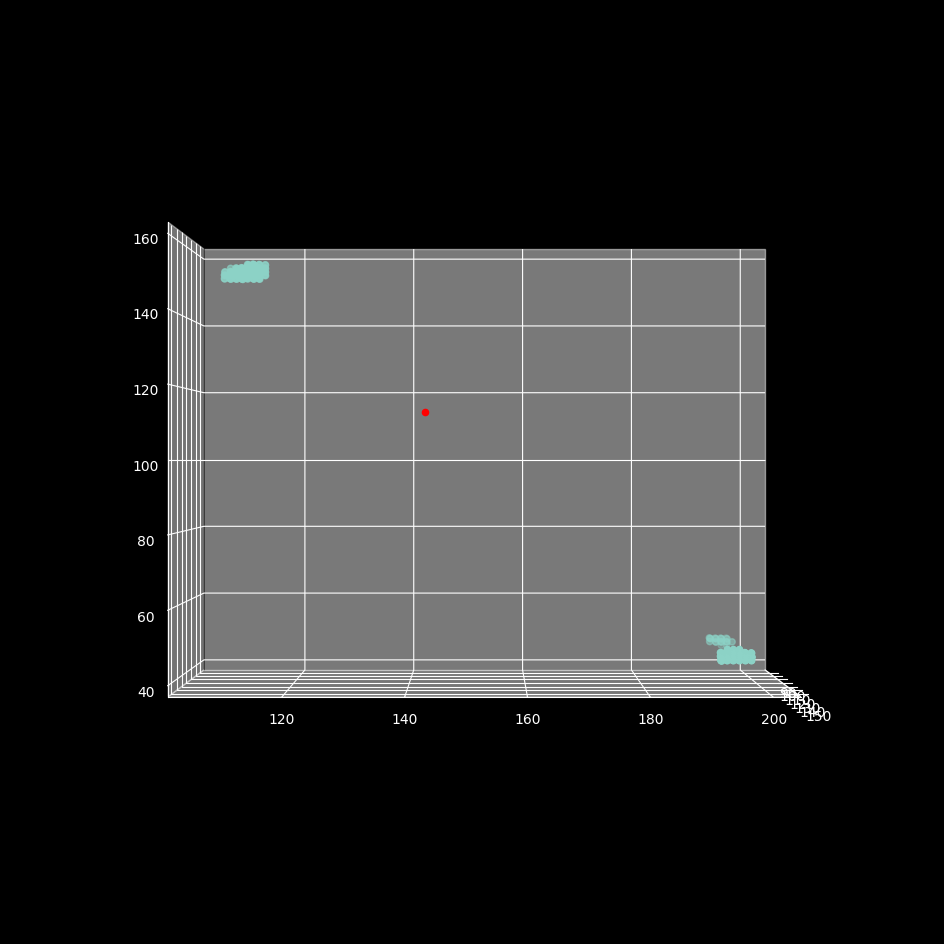

In [48]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pineal_points[:,0], pineal_points[:,1], pineal_points[:,2])
ax.scatter(centroid[0], centroid[1], centroid[2], c='red')
ax.view_init(azim=0, elev=0)

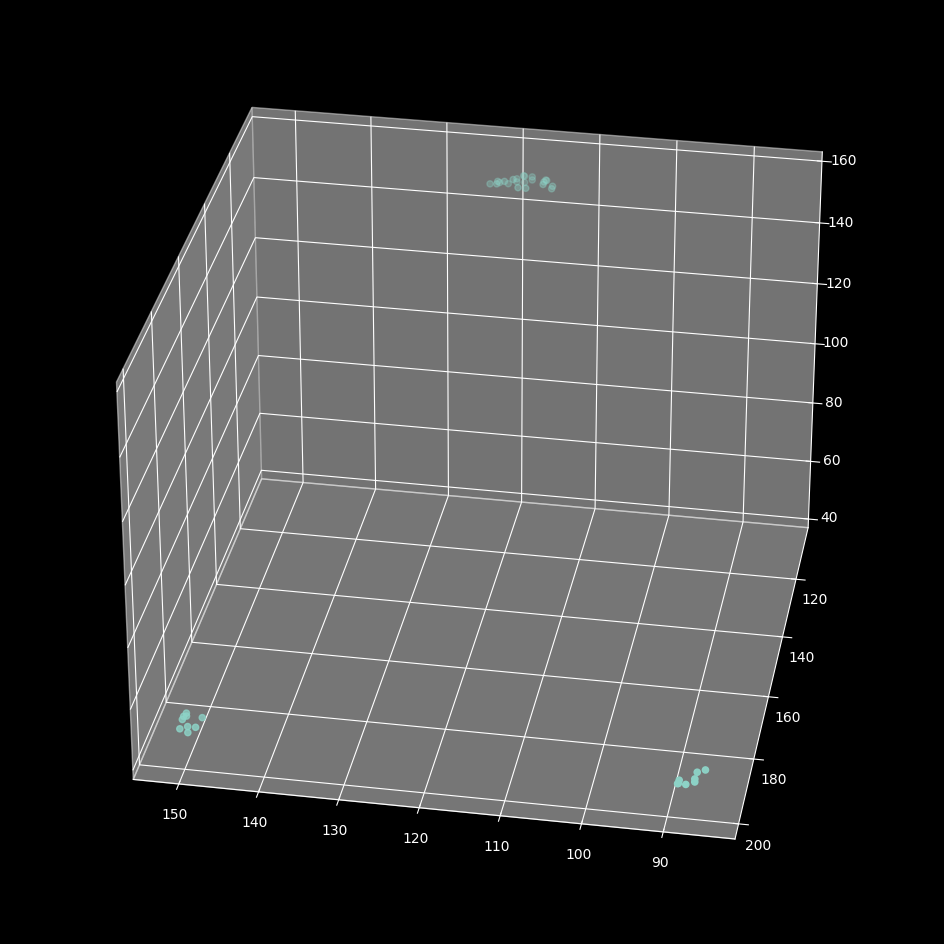

In [55]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(hull.points[hull.vertices, 0], hull.points[hull.vertices, 1], hull.points[hull.vertices, 2])
ax.view_init(azim=100, elev=30)